In [1]:
import numpy as np, matplotlib.pyplot as plt, drawSvg as draw
from os.path import join
from xml.dom import minidom
from svg.path import parse_path

/Users/raphaellaude/opt/anaconda3/lib/python3.9/site-packages/drawSvg/raster.py:18: RuntimeWarning: Failed to import CairoSVG. drawSvg will be unable to output PNG or other raster image formats. See https://github.com/cduck/drawSvg#prerequisites for more details.
Original OSError: no library called "cairo-2" was found
no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': dlopen(libcairo.so.2, 0x0002): tried: '/Users/raphaellaude/opt/anaconda3/lib/libcairo.so.2' (no such file), '/Users/raphaellaude/opt/anaconda3/lib/libcairo.so.2' (no such file), '/Users/raphaellaude/opt/anaconda3/lib/python3.9/site-packages/../../libcairo.so.2' (no such file), '/Users/raphaellaude/opt/anaconda3/lib/libcairo.so.2' (no such file), '/Users/raphaellaude/opt/anaconda3/bin/../lib/libcairo.so.2' (no such file), 'libcairo.so.2' (no such file), '/usr/local/lib/libcairo.so.2' (no such file), '/usr/lib/libcairo.so.2' (no such file), '/Users/raphaellaude/

In [16]:
def drawimg(img):
    '''Draw an image with some handy defaults enabled.
    '''
    n, m = img.shape
    plt.axis([0, m, 0, n])
    options = dict(cmap='viridis') # tab20b
    options['extent'] = [0, m, 0, n]

    # plot
    im = plt.imshow(img, **options)

    # settings
    ax = plt.gca()

    plt.box(None)
    plt.grid()
    ax.set_xticks([])
    ax.set_yticks([])

    return im

In [3]:
from xml.dom import minidom

p = r'./graphic_assets/hwy.svg'

doc = minidom.parse(p)  # parseString also exists
path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
doc.unlink()

In [4]:
type(doc)

xml.dom.minidom.Document

In [5]:
from dataclasses import dataclass

@dataclass
class Tile:
    """Tile data for generating terrain with a WFC alg."""
    name: str
    color: str
    draw: object = None

In [6]:
water = Tile('water', '#A6EEF0', draw.Rectangle) 
forest = Tile('forest', '#84CE6B', draw.Rectangle)
scrub = Tile('scrub', '#BCED6B', draw.Rectangle)
city = Tile('city', '#EDEDED', draw.Rectangle)
desert = Tile('desert', '#F7CE6F', draw.Rectangle)

In [61]:
rook = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
possible_rook_directions = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])


def wfc(shape, adj):
    X = np.full(shape, -1)
    x, y = shape
    P = np.full((x, y, len(adj)), 1)

    while (X < 0).any():
        X, P = collapse(X, P, adj)

    return X


def collapse(X, P, adj):
    if (X < 0).all():
        loc = random_loc(X.shape)
        X, P = update(X, P, loc, np.random.randint(0, len(adj)))
        return propagate(X, P, loc, adj)

    return X, P


def update(X, P, loc, v):
    x, y = loc
    X[x, y] = v
    print(X, loc, v)
    options = np.full((P.shape[2],), 0)
    options[v] = 1
    print(options)
    P[x, y] = options

    return X, P


def random_loc(shape):
    x, y = shape
    return np.random.randint(x), np.random.randint(y)


def propagate(X, P, loc, adj):
    to_change = [loc]

    while len(to_change) > 0:
        loc = to_change.pop()
        x, y = loc
        positions = [loc + d for d in possible_rook_directions if valid_loc(X.shape, loc + d)]

        for new_loc in positions:
            nx, ny = new_loc
            options = ((P[nx, ny] & adj).sum(axis=0) > 0) * 1

            if options.sum() == 0:
                raise KeyError('oops')
            elif options.sum() == 1:
                P[nx, ny] = options
                print(P[nx, ny], 'propagate last')
                X[nx, ny] = options.argmax()
                to_change.append((nx, ny))
            elif P[nx, ny].sum() < options.sum():
                P[nx, ny] = options
                print(P[nx, ny], 'propage less')
                to_change.append((nx, ny))

    return X, P


def valid_loc(shape, loc):
    x, y = loc
    return x >= 0 and y >= 0 and x < shape[0] and y < shape[1]

In [62]:
adj = np.array([
    [1, 1, 1, 0],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [0, 0, 1, 1],
])

x, y = 10, 10

X = np.full((x, y), -1)
P = np.full((x, y, len(adj)), 1)

In [63]:
X, P = collapse(X, P, adj)

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  2 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]] (1, 1) 2
[0 0 1 0]
[0 1] [0 0 1 0]
[0 0 1 0] propagate last
[2 1] [0 0 1 0]
[0 0 1 0] propagate last
[1 0] [0 0 1 0]
[0 0 1 0] propagate last
[1 2] [0 0 1 0]
[0 0 1 0] propagate last
[0 2] [0 0 1 0]
[0 0 1 0] propagate last
[2 2] [0 0 1 0]
[0 0 1 0] propagate last
[1 1] [0 0 1 0]
[0 0 1 0] propagate last
[1 3] [0 0 1 0]
[0 0 1 0] propagate last
[0 3] [0 0 1 0]
[0 0 1 0] propagate last
[2 3] [0 0 1 0]
[0 0 1 0] propagate last
[1 2] [0 0 1 0]
[0 0 1 0] propagate last
[1 4] [0 0 1 0]
[0 0 1 0] propagate last
[0 4] [0 0 1 0]
[0 0 1 0] propagate last
[2 4] [0 0 1 0]
[0 0 1 0] propagate last
[1 3] [0 0 1 0]
[0 0 1 0] propagate last
[1 5] [0 0 1 0]
[0 0 1 0] propagate

KeyboardInterrupt: 

In [64]:
P.sum(axis=2)

array([[4, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [4, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]])

In [12]:
P[3, 4]

array([1, 1, 1, 1])

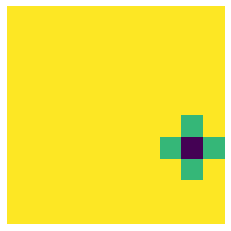

In [18]:
drawimg(P.sum(axis=2))

In [24]:
P[6, 9]

array([1, 1, 1, 0])

In [21]:
P[8, 9] | adj

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]])

In [26]:
adj

array([[1, 1, 1, 0],
       [1, 1, 0, 0],
       [1, 0, 1, 1],
       [0, 0, 1, 1]])

In [35]:
(P[6, 9] & adj)

array([[1, 1, 1, 0],
       [1, 1, 0, 0],
       [1, 0, 1, 0],
       [0, 0, 1, 0]])

In [40]:
((P[6, 9] & adj).sum(axis=0) > 0) * 1

array([1, 1, 1, 0])